# Is it a cat or a dog?

This is version 2 of the "Is it a cat or a dog?-notebook.

Unlike the first version, which focused on the straight path, this notebook does a little more with respect to training. Additionally, we are going to export the model.

## Step 1: Downloading the images

In [12]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [13]:
def search_images(term, max_images=150):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Step 1a: Downloading a cat and a dog

Let's download a cat and a dog picture as examples, and later for testing the predictions.

In [14]:
from fastdownload import download_url
from fastai.vision.all import *

Searching for 'cat picture'


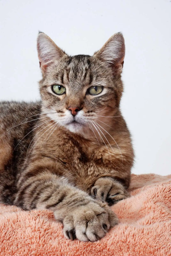

In [15]:
download_url(search_images('cat picture', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

Searching for 'dog picture'


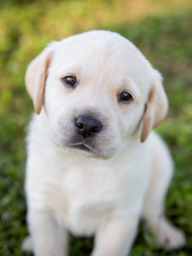

In [16]:
download_url(search_images('dog picture', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

### Step 1b: Download cats and dogs for the dataset

In [17]:
searches = 'cat','dog'
path = Path('cat_or_dog')
from time import sleep

In [18]:
# Introducing a new parameter to control if the download of the images should be done.
# If you want to download new images, simply set it to `True`
do_download = True

In [19]:
if do_download:
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o}'))
#        sleep(10)  # Pause between searches to avoid over-loading server
#        download_images(dest, urls=search_images(f'{o} photo'))
#        sleep(10)
#        download_images(dest, urls=search_images(f'{o} picture'))
#        sleep(10)
        print("resizing")
        resize_images(path/o, max_size=400, dest=path/o)

print("Download completed")

Searching for 'cat'
resizing


/home/chrwittm/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'dog'
resizing


/home/chrwittm/mambaforge/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Download completed


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

## Step 2: Train the model for the first time

### DataBlock / DataLoader

In [29]:
cats_dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')])

The above command has given us a `DataBlock` object. This is like a template for creating a `DataLoaders`.

We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [30]:
dls = cats_dogs.dataloaders(path, bs=32)

A `DataLoaders` includes validation and training `DataLoader`.

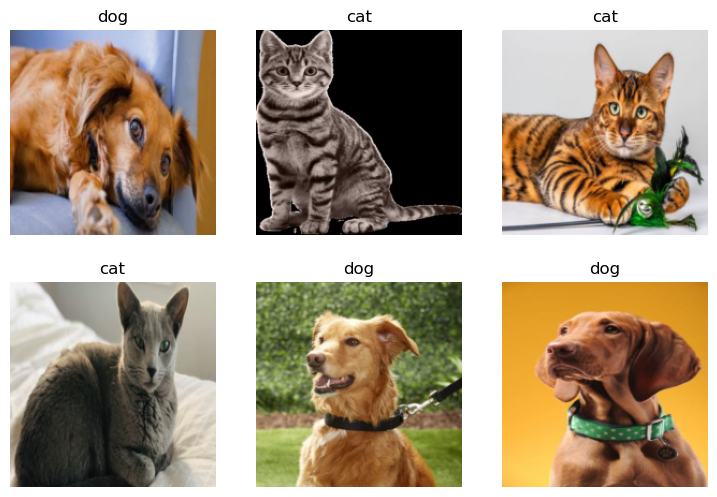

In [33]:
dls.show_batch(max_n=6)

### Data Augmentation

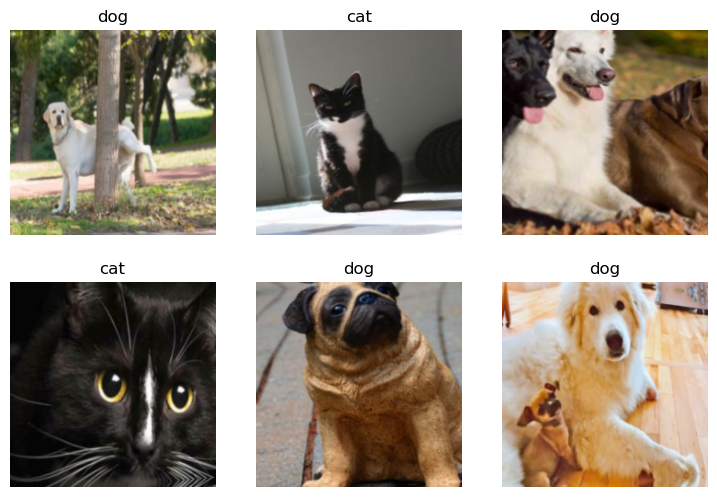

In [41]:
cats_dogs_aug = cats_dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats_dogs_aug.dataloaders(path)
dls.show_batch(max_n=6)

### Training

In [42]:
# when performing the next cell, I received a warning, that the resnet18 will need to be called differently in the future.
# to avoid the confusing message (it confused me a lot), I decided to simply suppress the warning as suggested here:
# https://github.com/JaidedAI/EasyOCR/issues/766
# After all, it is just a warning ;)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [43]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.120845,0.182411,0.090909,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.346659,0.056278,0.018182,00:28
1,0.231636,0.030606,0.000000,00:37
2,0.166926,0.030014,0.000000,00:40


Wow, zero errors!

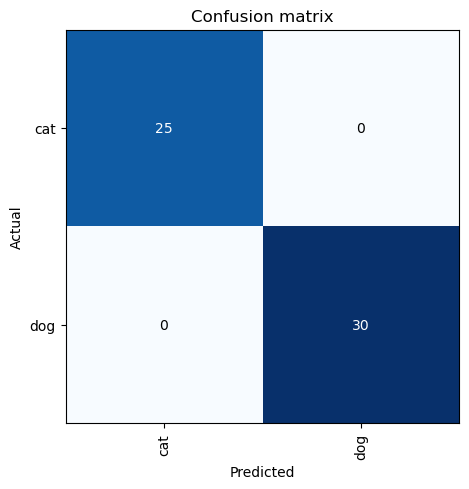

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

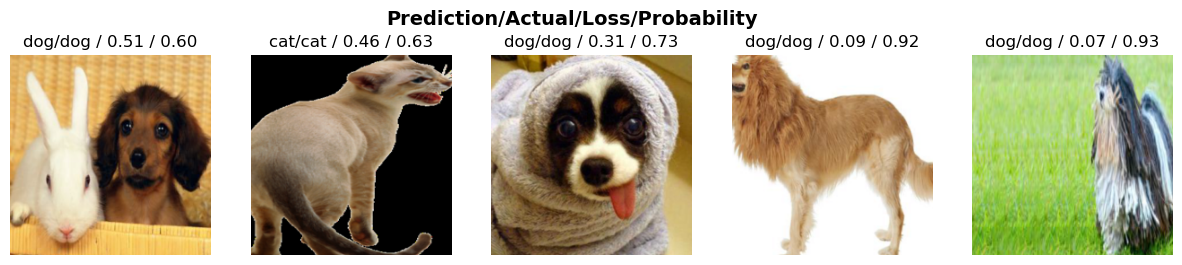

In [46]:
interp.plot_top_losses(5, nrows=1)

In [49]:
from fastai.vision.widgets import *

In [50]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Nothing really to delete.

In [51]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 3: Test the model

In [61]:
def predict_image(path):
    pred,pred_idx,probs = learn.predict(PILImage.create(path))
    print(f"This is a {pred}.")
    print_probs(learn.dls.vocab, probs)
    

def print_probs(vocab, probs):
    for i in range(len(vocab)):
        print(f"Probability it's a {vocab[i]}: {probs[i]:.4f}")

Let's test the cat picture:

In [62]:
predict_image('cat.jpg')

This is a cat.
Probability it's a cat: 1.0000
Probability it's a dog: 0.0000


Let's test the dog picture:

In [63]:
predict_image('dog.jpg')

This is a dog.
Probability it's a cat: 0.0000
Probability it's a dog: 1.0000


## Step 4: Export the model

In [65]:
learn.export()

From Here, let's continue in the next notebook, which contains the app.